<h1>6. Multiclass classification </h1>

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('../student-mat.csv', sep=';')
df['finalResult'] = df["G3"].apply(lambda x: 'pass' if x> 9 else 'fail')
df['academicGrade'] = df["G3"].apply(lambda x: 'A' if x>15 and x<21 else 'B' if x>13 and x<16 else 'C' if x>11 and x<14 else 'D' if x>9 and x<12 else 'E' )

<h3>6.1 Preprocess the data. Use the function « ColumnTransformer » to do that. Explain precisely each step, in particular when you drop, impute or transform the variables. Try several approachs.</h3>

 *il y a-t-il des valeurs manquants ?*

In [3]:
df.isnull().any()

school           False
sex              False
age              False
address          False
famsize          False
Pstatus          False
Medu             False
Fedu             False
Mjob             False
Fjob             False
reason           False
guardian         False
traveltime       False
studytime        False
failures         False
schoolsup        False
famsup           False
paid             False
activities       False
nursery          False
higher           False
internet         False
romantic         False
famrel           False
freetime         False
goout            False
Dalc             False
Walc             False
health           False
absences         False
G1               False
G2               False
G3               False
finalResult      False
academicGrade    False
dtype: bool

 *  *identifier les valeur quantitatifs et qualitatifs*

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   school         395 non-null    object
 1   sex            395 non-null    object
 2   age            395 non-null    int64 
 3   address        395 non-null    object
 4   famsize        395 non-null    object
 5   Pstatus        395 non-null    object
 6   Medu           395 non-null    int64 
 7   Fedu           395 non-null    int64 
 8   Mjob           395 non-null    object
 9   Fjob           395 non-null    object
 10  reason         395 non-null    object
 11  guardian       395 non-null    object
 12  traveltime     395 non-null    int64 
 13  studytime      395 non-null    int64 
 14  failures       395 non-null    int64 
 15  schoolsup      395 non-null    object
 16  famsup         395 non-null    object
 17  paid           395 non-null    object
 18  activities     395 non-null   

**Using as predictors the first 32 variables.**

In [5]:
from sklearn.model_selection import train_test_split

data_y = df['academicGrade']
data_x = df.drop(['finalResult','G3','academicGrade'], axis = 1)

x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,test_size=0.20,random_state=1)

data_x.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,1,1,3,6,5,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,no,5,3,3,1,1,3,4,5,5
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,no,4,3,2,2,3,3,10,7,8
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,3,2,2,1,1,5,2,15,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,4,3,2,1,2,5,4,6,10


**Preprocessing**

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

qualitative_var = ["school","sex","address","famsize","Pstatus","Mjob","Fjob","reason","guardian","schoolsup","famsup","paid","activities","nursery","higher","internet","romantic"]
quantitative_var = ['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','absences','G1','G2']

#vu que academicGrade et finalResult sont issus de G3, cela n'a pas de sens de les avoir dans le Model

qualitative_pipeline = Pipeline([
     ('encoder', OneHotEncoder(drop = 'first'))
])

quantitative_pipeline = Pipeline([
     ('min_max_scaler', MinMaxScaler())
])
 
preprocessor = ColumnTransformer(remainder='passthrough',
                                 transformers=[
                                   ('transform_quantitatif',qualitative_pipeline, qualitative_var),
                                    ('transform_qualitatif',quantitative_pipeline,quantitative_var),
                                 ])

<h3>K-NearestNeighbors</h3> 

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

KNN = Pipeline(
    steps=[("preprocess",preprocessor),
           ("KNN",KNeighborsClassifier())])

hyperKNN = {'KNN__n_neighbors':[3,4,5,6,7,8],'KNN__p':[1,2],'KNN__weights':['uniform','distance']}
gridKNN = GridSearchCV(KNN,hyperKNN,cv=3)

gridKNN.fit(x_train,y_train)

modelKNN = gridKNN.best_estimator_
gridKNN.best_params_ 

{'KNN__n_neighbors': 6, 'KNN__p': 1, 'KNN__weights': 'distance'}

 * <h4>confusion matrix, precision, recall ,F1 score.</h4>

In [8]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

 

metric_results = {}
def metrics( model, name, result_dic ):
    
    result = model.predict(x_test)
    confusion_m = confusion_matrix(result, y_test)
    ConfusionMatrixDisplay(confusion_m).plot()
    
    sc = model.score(x_test,y_test)
    ps = precision_score(result,y_test,average='macro')
    rs = recall_score(result,y_test,average='macro')
    f1 = f1_score(result,y_test,average='macro')
    
    print(name +' Score :',sc)
    result_dic[name +' Score' ] = sc
    print(name +' Precision Score :',ps)
    result_dic[name +' Precision Score' ] = ps
    print(name +' Recall Score :',rs)
    result_dic[name +' Recall Score' ] = rs
    print(name + ' F1 Score :',f1)
    result_dic[name +' F1 Score' ] = f1
    
     
    
    
#pour evaluer les resultats je fais une prediction sur mes donnees de x_test et 



KNeighbors Score : 0.3670886075949367
KNeighbors Precision Score : 0.27166666666666667
KNeighbors Recall Score : 0.2641414141414141
KNeighbors F1 Score : 0.26096491228070173


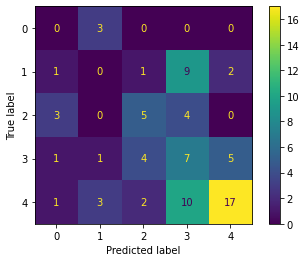

In [9]:
metrics(modelKNN, 'KNeighbors', metric_results)

<h3>Support Vector Machine classifier.</h3> 

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

SVM = Pipeline(
    steps=[("preprocess",preprocessor),
           ("SVM",SVC())])

hyperSVM = {'SVM__C':[1,2,3],'SVM__kernel':['linear', 'poly', 'rbf', 'sigmoid'],'SVM__decision_function_shape':['ovo','ovr']}
gridSVM = GridSearchCV(SVM,hyperSVM,cv=3)

gridSVM.fit(x_train,y_train)
modelSVM = gridSVM.best_estimator_

 

* <h4>confusion matrix, precision, recall ,F1 score.</h4>

Support Vector Machine Score : 0.4936708860759494
Support Vector Machine Precision Score : 0.3854761904761904
Support Vector Machine Recall Score : 0.38623543123543125
Support Vector Machine F1 Score : 0.3748985507246377


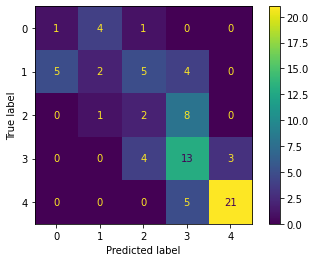

In [11]:
metrics(modelSVM, 'Support Vector Machine', metric_results)

<h3> Linear Discriminant Analysis classifier.</h3> 

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV

LDA = Pipeline(
    steps=[("preprocess",preprocessor),
           ("LDA",LinearDiscriminantAnalysis())])

hyperLDA = {'LDA__solver':['svd', 'lsqr', 'eigen'],'LDA__store_covariance':['True','False']}
gridLDA = GridSearchCV(LDA,hyperLDA,cv=3)

gridLDA.fit(x_train,y_train)
modelLDA = gridLDA.best_estimator_

In [13]:
LinearDiscriminantAnalysis().get_params().keys() 

dict_keys(['covariance_estimator', 'n_components', 'priors', 'shrinkage', 'solver', 'store_covariance', 'tol'])

 * <h4>confusion matrix, precision, recall ,F1 score.</h4>

Linear Discriminant Analysis Score : 0.5822784810126582
Linear Discriminant Analysis Precision Score : 0.525952380952381
Linear Discriminant Analysis Recall Score : 0.5247619047619048
Linear Discriminant Analysis F1 Score : 0.5138193969772917


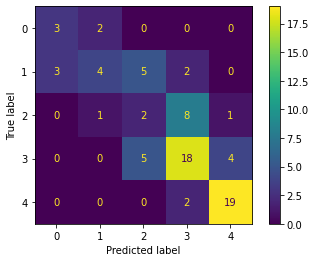

In [14]:
metrics(modelLDA, 'Linear Discriminant Analysis', metric_results)

<h3> Logistic Regression classifier.</h3> 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

LR = Pipeline(
    steps=[("preprocess",preprocessor),
           ("LR",LogisticRegression())])

hyperLR = {'LR__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],'LR__max_iter':[300,500]}
gridLR = GridSearchCV(LR,hyperLR,cv=3)

gridLR.fit(x_train,y_train)
modelLR = gridLR.best_estimator_

In [16]:
gridLR.best_params_ 

{'LR__max_iter': 300, 'LR__solver': 'newton-cg'}

 * <h4>confusion matrix, precision, recall ,F1 score.</h4>

Logistic Regression Score : 0.46835443037974683
Logistic Regression Precision Score : 0.3738095238095238
Logistic Regression Recall Score : 0.3815126050420168
Logistic Regression F1 Score : 0.3488410561005842


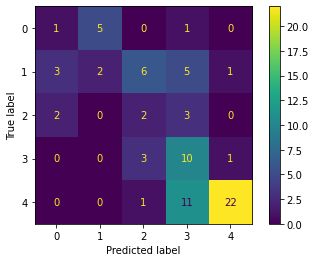

In [17]:
metrics(modelLR, 'Logistic Regression', metric_results)

<h3>Decision Tree classifier.</h3> 

In [18]:
from sklearn.tree import DecisionTreeClassifier

tree = Pipeline(
    steps=[("preprocess",preprocessor),
           ("tree",DecisionTreeClassifier(random_state=0))])

hypertree = {"tree__criterion":("gini", "entropy"), "tree__splitter": ["best","random"]}
gridtree = GridSearchCV(tree,hypertree,cv=3)

gridtree.fit(x_train,y_train)
modeltree = gridtree.best_estimator_

In [19]:
gridtree.best_params_ 

{'tree__criterion': 'gini', 'tree__splitter': 'best'}

 * <h4>confusion matrix, precision, recall ,F1 score.</h4>

Decision Tree Classifier Score : 0.569620253164557
Decision Tree Classifier Precision Score : 0.47523809523809524
Decision Tree Classifier Recall Score : 0.46835518748562227
Decision Tree Classifier F1 Score : 0.46766840262955683


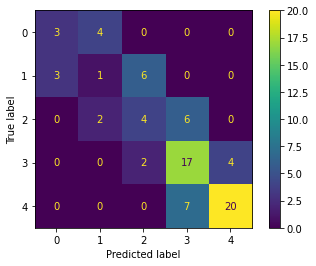

In [20]:
metrics(modeltree, 'Decision Tree Classifier', metric_results)

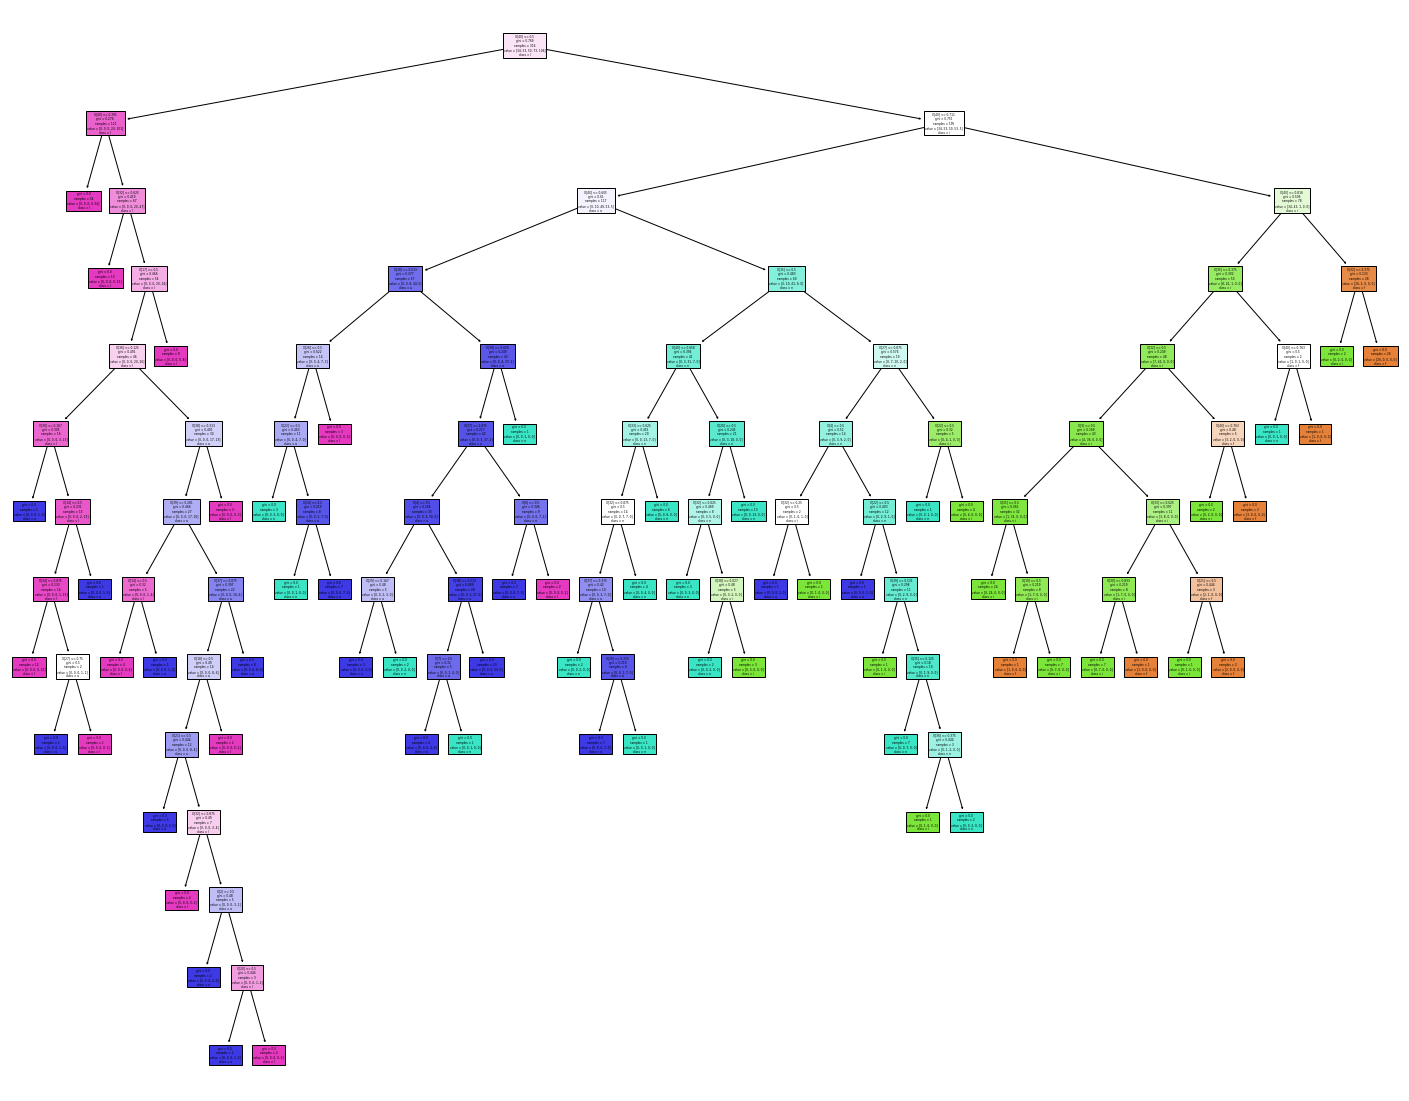

In [33]:
import matplotlib.pyplot as plt
from sklearn import tree
temp = quantitative_var.copy()
result = gridtree.best_estimator_
features = temp.append(result['preprocess'].transformers_[0][1][0].get_feature_names())
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(result['tree'], 
                feature_names=features,  
                   class_names='finalResult',
                   filled=True)
fig.savefig("decistion_tree_multi.png")

<h3>Decision Tree classifier.</h3> 

Voting Score : 0.5316455696202531
Voting Precision Score : 0.4154761904761905
Voting Recall Score : 0.44676691729323303
Voting F1 Score : 0.41182922340817074


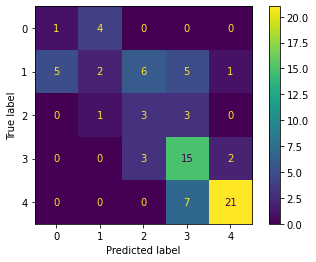

In [22]:
from sklearn.ensemble import VotingClassifier
 
voting = VotingClassifier(estimators=[
        ('KNN', modelKNN),('Support vector machine', modelSVM), ('Logistic Regression', modelLR), ('Tree', modeltree)], voting='hard')
voting = voting.fit(x_train, y_train)
metrics(voting,"Voting",metric_results)


<h3>Random Forest Classifier.</h3> 

In [23]:
from sklearn.ensemble import RandomForestClassifier
 

RF = Pipeline(
    steps=[("preprocess",preprocessor),
           ("RF",RandomForestClassifier())])

hyperRF = {'RF__n_estimators':[100,150,200],'RF__criterion':['gini','entropy'],'RF__max_features':['auto','log2']},
gridRF = GridSearchCV(RF,hyperRF,cv=3)

gridRF.fit(x_train,y_train)
modelRF= gridLR.best_estimator_

In [24]:
gridRF.best_params_ 

{'RF__criterion': 'entropy',
 'RF__max_features': 'auto',
 'RF__n_estimators': 200}

 * <h4>confusion matrix, precision, recall ,F1 score.</h4>

Random Forest Classifier Score : 0.46835443037974683
Random Forest Classifier Precision Score : 0.3738095238095238
Random Forest Classifier Recall Score : 0.3815126050420168
Random Forest Classifier F1 Score : 0.3488410561005842


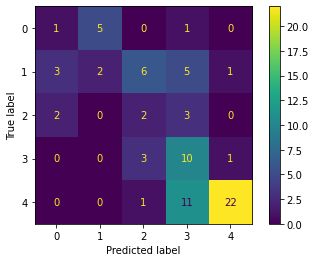

In [25]:
metrics(modelRF, 'Random Forest Classifier', metric_results)

<h3> Gradient Boosting Classifier.</h3> 

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
 

GB = Pipeline(
    steps=[("preprocess",preprocessor),
           ("GB",GradientBoostingClassifier())])

hyperGB = {'GB__n_estimators':[100,150,200],'GB__loss':['deviance'],'GB__criterion':['friedman_mse','mse',]},
gridGB = GridSearchCV(GB,hyperGB,cv=3)

gridGB.fit(x_train,y_train)
modelGB= gridGB.best_estimator_

In [27]:
gridGB.best_params_ 

{'GB__criterion': 'friedman_mse',
 'GB__loss': 'deviance',
 'GB__n_estimators': 100}

 * <h4>confusion matrix, precision, recall ,F1 score.</h4>

Gradient Boosting Classifier Score : 0.6455696202531646
Gradient Boosting Classifier Precision Score : 0.589047619047619
Gradient Boosting Classifier Recall Score : 0.5880196078431372
Gradient Boosting Classifier F1 Score : 0.5832183908045978


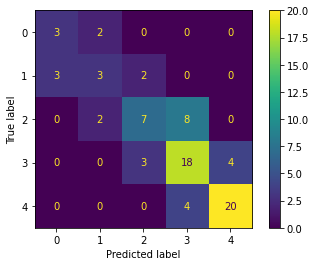

In [28]:
metrics(modelGB, 'Gradient Boosting Classifier', metric_results)

<h3> Ada Boost Classifier.</h3> 

In [29]:
from sklearn.ensemble import AdaBoostClassifier
 

AB = Pipeline(
    steps=[("preprocess",preprocessor),
           ("AB",AdaBoostClassifier())])

hyperAB = {'AB__n_estimators':[50,100,150],'AB__algorithm':['SAMME','SAMME.R'],'AB__learning_rate':[1,2]},
gridAB = GridSearchCV(AB,hyperAB,cv=3)

gridAB.fit(x_train,y_train)
modelAB= gridAB.best_estimator_

In [30]:
gridAB.best_params_ 

{'AB__algorithm': 'SAMME', 'AB__learning_rate': 1, 'AB__n_estimators': 50}

 * <h4>confusion matrix, precision, recall ,F1 score.</h4>

Ada Boost Classifier Score : 0.7088607594936709
Ada Boost Classifier Precision Score : 0.6583333333333333
Ada Boost Classifier Recall Score : 0.5546666666666666
Ada Boost Classifier F1 Score : 0.5895767195767195


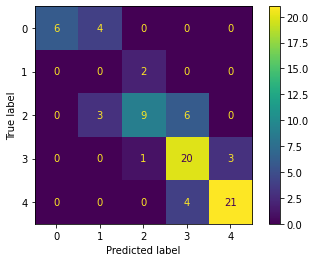

In [31]:
metrics(modelAB, 'Ada Boost Classifier', metric_results)

<h2>Results</h2>

In [32]:
from ipy_table import *

# dictionary
dict = metric_results

# lists
temp = []
dictList = []

# convert the dictionary to a list
for key, value in dict.items():
    temp = [key,value]
    dictList.append(temp)

# create table with make_table
make_table(dictList)

# apply some styles to the table after it is created
set_column_style(0, width='100', bold=True, color='hsla(225, 80%, 94%, 1)')
set_column_style(1, width='100')

# render the table
render()

KNeighbors Score,0.3671
KNeighbors Precision Score,0.2717
KNeighbors Recall Score,0.2641
KNeighbors F1 Score,0.2610
Support Vector Machine Score,0.4937
Support Vector Machine Precision Score,0.3855
Support Vector Machine Recall Score,0.3862
Support Vector Machine F1 Score,0.3749
Linear Discriminant Analysis Score,0.5823
Linear Discriminant Analysis Precision Score,0.5260
Linear Discriminant Analysis Recall Score,0.5248
